In this notebook you will find a CNN (feature extraction in the convolutions and poolings + classification in the linear layers) for the CIFAR10 dataset using pytorch.

In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 22 (delta 3), reused 7 (delta 1), pack-reused 8
Unpacking objects: 100% (22/22), done.


In [ ]:
cd deep-learning-polytech-tp6-7

/content/deep-learning-polytech-tp6-7


In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), ceil_mode=True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False, normalize=True):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """

    #if normalize:
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=45),
            transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.Normalize(mean=[0.491, 0.482, 0.447],
                          std=[0.202, 0.199, 0.201])
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(28),
            transforms.Normalize(mean=[0.491, 0.482, 0.447],
                        std=[0.202, 0.199, 0.201])
        ]))
      


    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=10, cuda=False, normalize=True):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda, normalize)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[TRAIN Batch 000/391]	Time 1.298s (1.298s)	Loss 2.3011 (2.3011)	Prec@1   9.4 (  9.4)	Prec@5  50.8 ( 50.8)


<Figure size 432x288 with 0 Axes>

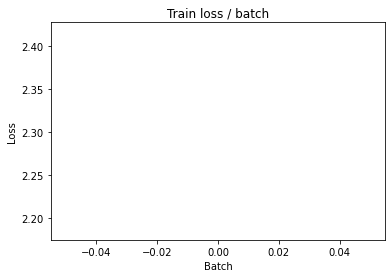

[TRAIN Batch 200/391]	Time 0.021s (0.213s)	Loss 2.1766 (2.1599)	Prec@1  16.4 ( 19.7)	Prec@5  74.2 ( 68.6)


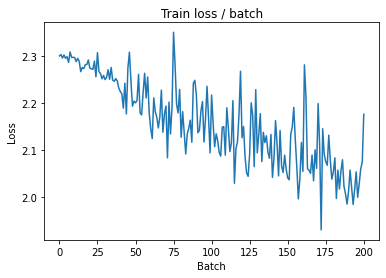


===============> Total time 82s	Avg loss 2.0693	Avg Prec@1 23.96 %	Avg Prec@5 73.96 %

[EVAL Batch 000/079]	Time 0.183s (0.183s)	Loss 1.7575 (1.7575)	Prec@1  39.1 ( 39.1)	Prec@5  85.2 ( 85.2)

===============> Total time 3s	Avg loss 1.7918	Avg Prec@1 33.44 %	Avg Prec@5 84.45 %



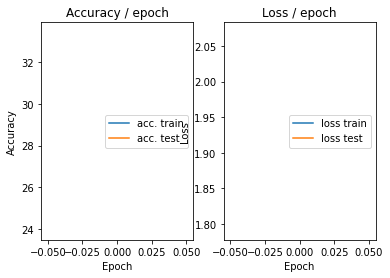

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.547s (0.547s)	Loss 1.9879 (1.9879)	Prec@1  26.6 ( 26.6)	Prec@5  78.9 ( 78.9)


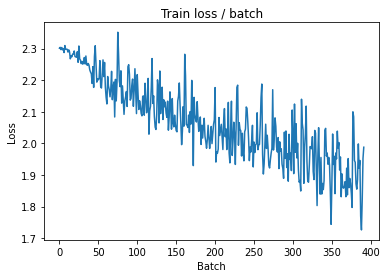

[TRAIN Batch 200/391]	Time 0.376s (0.214s)	Loss 1.7606 (1.8454)	Prec@1  34.4 ( 33.3)	Prec@5  87.5 ( 83.7)


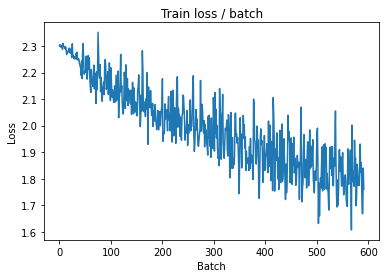


===============> Total time 83s	Avg loss 1.7981	Avg Prec@1 34.86 %	Avg Prec@5 85.00 %

[EVAL Batch 000/079]	Time 0.185s (0.185s)	Loss 1.5901 (1.5901)	Prec@1  44.5 ( 44.5)	Prec@5  85.9 ( 85.9)

===============> Total time 3s	Avg loss 1.5989	Avg Prec@1 41.78 %	Avg Prec@5 89.36 %



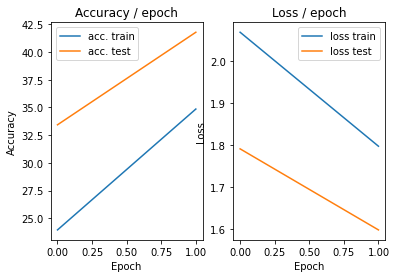

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.540s (0.540s)	Loss 1.8161 (1.8161)	Prec@1  28.1 ( 28.1)	Prec@5  83.6 ( 83.6)


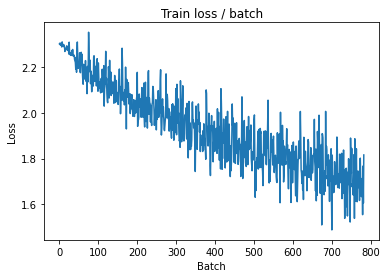

[TRAIN Batch 200/391]	Time 0.026s (0.213s)	Loss 1.6947 (1.6744)	Prec@1  39.1 ( 40.1)	Prec@5  85.9 ( 88.1)


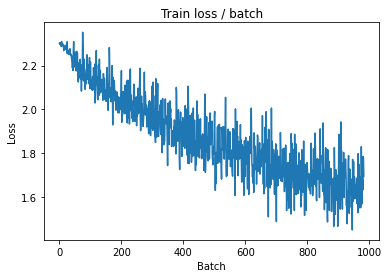


===============> Total time 83s	Avg loss 1.6443	Avg Prec@1 41.32 %	Avg Prec@5 88.64 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 1.4473 (1.4473)	Prec@1  51.6 ( 51.6)	Prec@5  93.8 ( 93.8)

===============> Total time 3s	Avg loss 1.5002	Avg Prec@1 47.81 %	Avg Prec@5 92.15 %



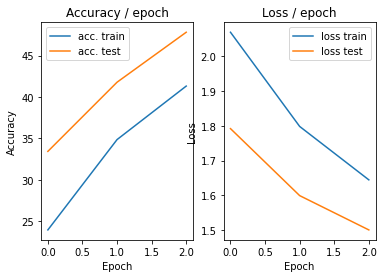

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.558s (0.558s)	Loss 1.7493 (1.7493)	Prec@1  42.2 ( 42.2)	Prec@5  85.2 ( 85.2)


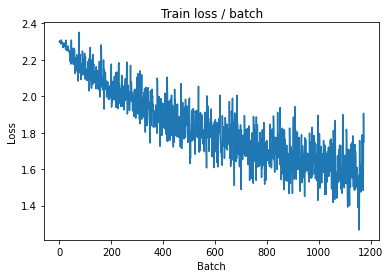

[TRAIN Batch 200/391]	Time 0.408s (0.216s)	Loss 1.4677 (1.5384)	Prec@1  43.8 ( 44.6)	Prec@5  93.8 ( 90.4)


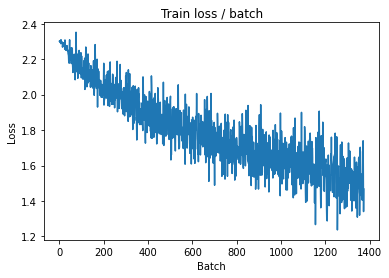


===============> Total time 83s	Avg loss 1.5234	Avg Prec@1 45.61 %	Avg Prec@5 90.60 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.3081 (1.3081)	Prec@1  55.5 ( 55.5)	Prec@5  95.3 ( 95.3)

===============> Total time 3s	Avg loss 1.3411	Avg Prec@1 54.07 %	Avg Prec@5 93.95 %



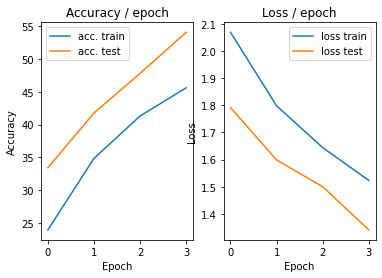

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.546s (0.546s)	Loss 1.6054 (1.6054)	Prec@1  46.1 ( 46.1)	Prec@5  86.7 ( 86.7)


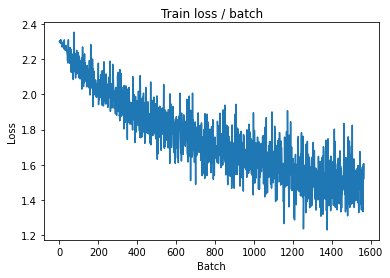

[TRAIN Batch 200/391]	Time 0.206s (0.216s)	Loss 1.3516 (1.4430)	Prec@1  50.0 ( 48.7)	Prec@5  95.3 ( 92.1)


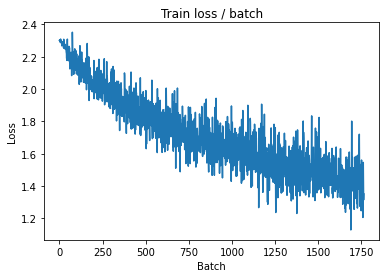


===============> Total time 83s	Avg loss 1.4356	Avg Prec@1 49.14 %	Avg Prec@5 91.96 %

[EVAL Batch 000/079]	Time 0.209s (0.209s)	Loss 1.1891 (1.1891)	Prec@1  56.2 ( 56.2)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 1.2625	Avg Prec@1 55.28 %	Avg Prec@5 94.20 %



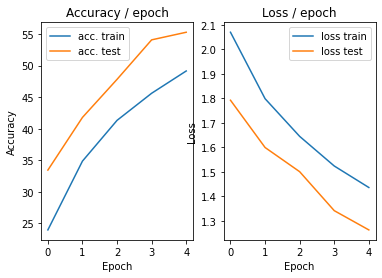

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.556s (0.556s)	Loss 1.4455 (1.4455)	Prec@1  42.2 ( 42.2)	Prec@5  96.9 ( 96.9)


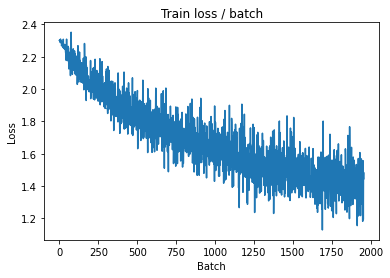

[TRAIN Batch 200/391]	Time 0.150s (0.215s)	Loss 1.2958 (1.3768)	Prec@1  61.7 ( 51.2)	Prec@5  95.3 ( 92.8)


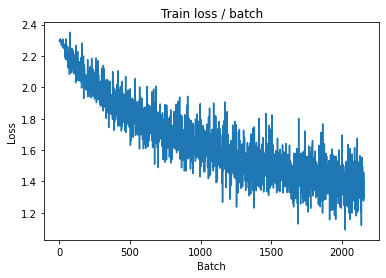


===============> Total time 83s	Avg loss 1.3624	Avg Prec@1 51.78 %	Avg Prec@5 92.96 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 1.1237 (1.1237)	Prec@1  60.9 ( 60.9)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 1.2048	Avg Prec@1 57.76 %	Avg Prec@5 94.71 %



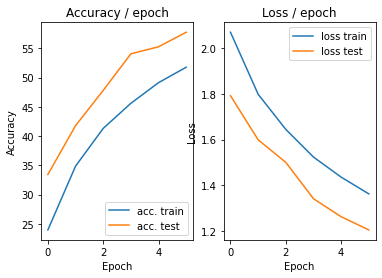

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.538s (0.538s)	Loss 1.3577 (1.3577)	Prec@1  51.6 ( 51.6)	Prec@5  93.0 ( 93.0)


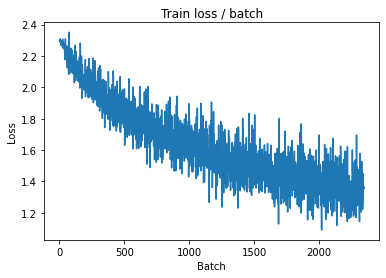

[TRAIN Batch 200/391]	Time 0.063s (0.215s)	Loss 1.2100 (1.3054)	Prec@1  57.8 ( 53.5)	Prec@5  95.3 ( 93.8)


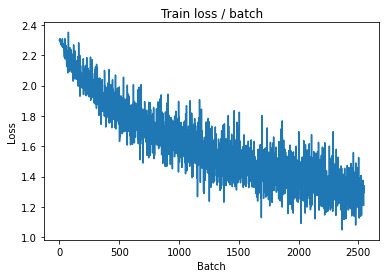


===============> Total time 84s	Avg loss 1.3072	Avg Prec@1 53.86 %	Avg Prec@5 93.54 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 1.1382 (1.1382)	Prec@1  60.2 ( 60.2)	Prec@5  96.1 ( 96.1)

===============> Total time 3s	Avg loss 1.1828	Avg Prec@1 57.35 %	Avg Prec@5 95.22 %



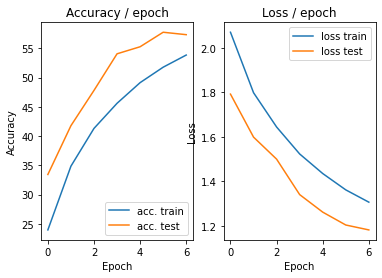

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.552s (0.552s)	Loss 1.4544 (1.4544)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)


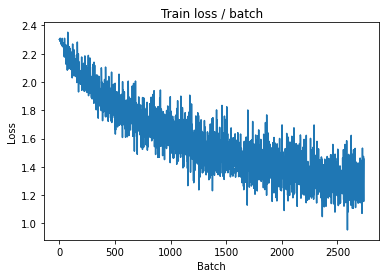

[TRAIN Batch 200/391]	Time 0.394s (0.217s)	Loss 1.2693 (1.2649)	Prec@1  57.8 ( 55.3)	Prec@5  94.5 ( 94.3)


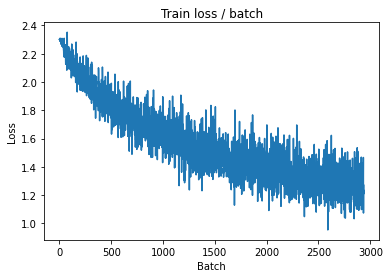


===============> Total time 84s	Avg loss 1.2600	Avg Prec@1 55.60 %	Avg Prec@5 94.13 %

[EVAL Batch 000/079]	Time 0.195s (0.195s)	Loss 1.0361 (1.0361)	Prec@1  61.7 ( 61.7)	Prec@5  96.9 ( 96.9)

===============> Total time 3s	Avg loss 1.0839	Avg Prec@1 61.85 %	Avg Prec@5 96.08 %



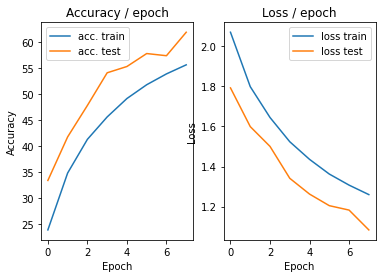

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.557s (0.557s)	Loss 1.0138 (1.0138)	Prec@1  64.8 ( 64.8)	Prec@5  96.1 ( 96.1)


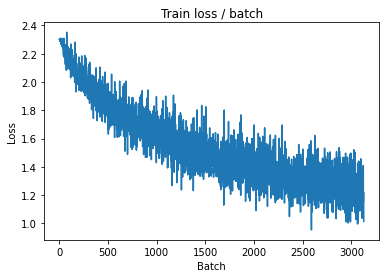

[TRAIN Batch 200/391]	Time 0.019s (0.214s)	Loss 1.0632 (1.2239)	Prec@1  63.3 ( 56.8)	Prec@5  99.2 ( 94.6)


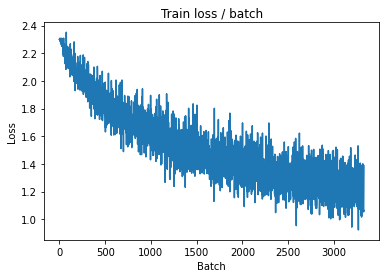


===============> Total time 83s	Avg loss 1.2154	Avg Prec@1 56.97 %	Avg Prec@5 94.60 %

[EVAL Batch 000/079]	Time 0.181s (0.181s)	Loss 1.0373 (1.0373)	Prec@1  63.3 ( 63.3)	Prec@5  96.9 ( 96.9)

===============> Total time 3s	Avg loss 1.0867	Avg Prec@1 61.77 %	Avg Prec@5 96.15 %



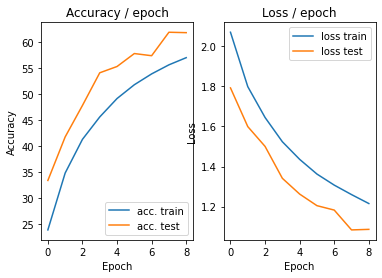

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.557s (0.557s)	Loss 1.0483 (1.0483)	Prec@1  60.2 ( 60.2)	Prec@5  94.5 ( 94.5)


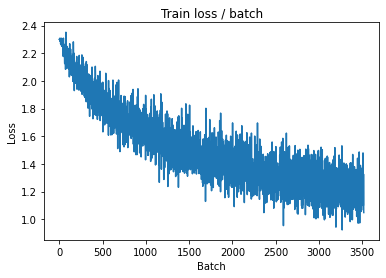

[TRAIN Batch 200/391]	Time 0.382s (0.216s)	Loss 1.1925 (1.1850)	Prec@1  59.4 ( 58.6)	Prec@5  93.0 ( 94.7)


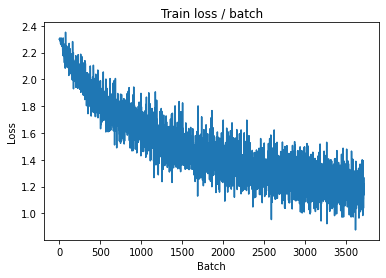


===============> Total time 83s	Avg loss 1.1818	Avg Prec@1 58.44 %	Avg Prec@5 94.79 %

[EVAL Batch 000/079]	Time 0.206s (0.206s)	Loss 1.0340 (1.0340)	Prec@1  64.8 ( 64.8)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 1.0428	Avg Prec@1 63.68 %	Avg Prec@5 96.36 %



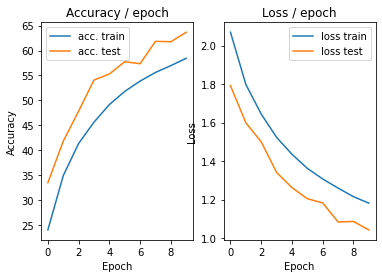

In [ ]:
main(128, 0.1, cuda=True)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 2.3046 (2.3046)	Prec@1  10.2 ( 10.2)	Prec@5  38.3 ( 38.3)


<Figure size 432x288 with 0 Axes>

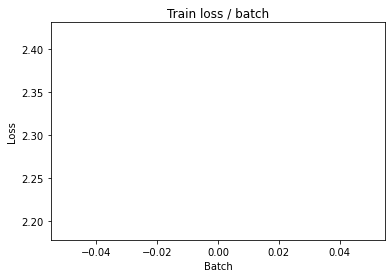

[TRAIN Batch 200/391]	Time 0.017s (0.032s)	Loss 2.0985 (2.2372)	Prec@1  19.5 ( 15.9)	Prec@5  71.9 ( 61.8)


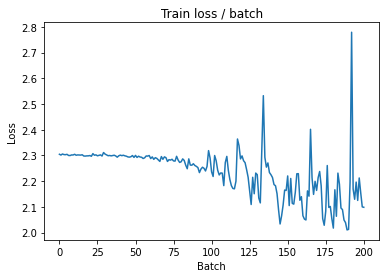


===============> Total time 12s	Avg loss 2.1481	Avg Prec@1 20.72 %	Avg Prec@5 68.86 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 1.9221 (1.9221)	Prec@1  28.1 ( 28.1)	Prec@5  82.0 ( 82.0)

===============> Total time 2s	Avg loss 1.9854	Avg Prec@1 27.02 %	Avg Prec@5 78.42 %



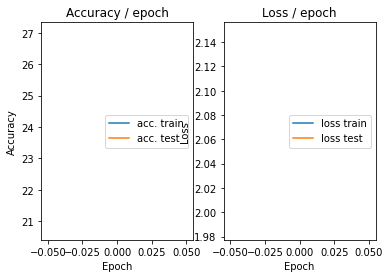

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 2.0222 (2.0222)	Prec@1  29.7 ( 29.7)	Prec@5  78.1 ( 78.1)


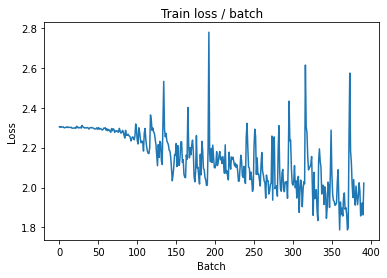

[TRAIN Batch 200/391]	Time 0.021s (0.031s)	Loss 1.5513 (1.8078)	Prec@1  44.5 ( 34.8)	Prec@5  88.3 ( 85.2)


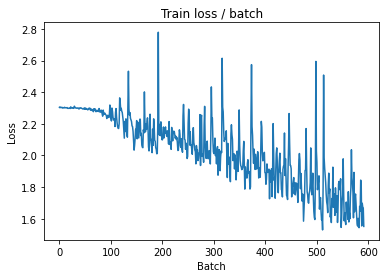


===============> Total time 12s	Avg loss 1.7156	Avg Prec@1 38.15 %	Avg Prec@5 87.27 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 1.5725 (1.5725)	Prec@1  39.8 ( 39.8)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5542	Avg Prec@1 43.07 %	Avg Prec@5 90.00 %



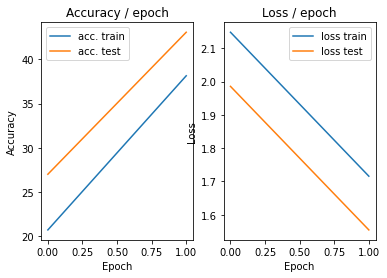

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 1.5571 (1.5571)	Prec@1  42.2 ( 42.2)	Prec@5  93.8 ( 93.8)


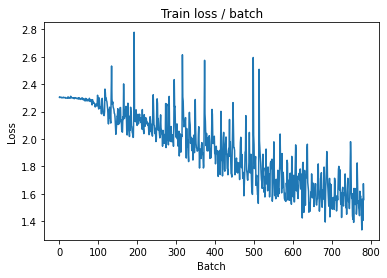

[TRAIN Batch 200/391]	Time 0.018s (0.031s)	Loss 1.5205 (1.4767)	Prec@1  48.4 ( 46.8)	Prec@5  89.8 ( 92.0)


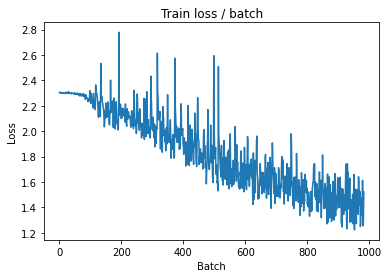


===============> Total time 12s	Avg loss 1.4373	Avg Prec@1 48.37 %	Avg Prec@5 92.44 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.2436 (1.2436)	Prec@1  62.5 ( 62.5)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.3193	Avg Prec@1 53.07 %	Avg Prec@5 93.74 %



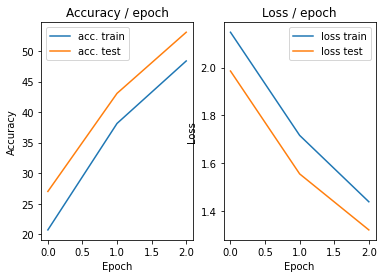

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 1.2938 (1.2938)	Prec@1  56.2 ( 56.2)	Prec@5  93.0 ( 93.0)


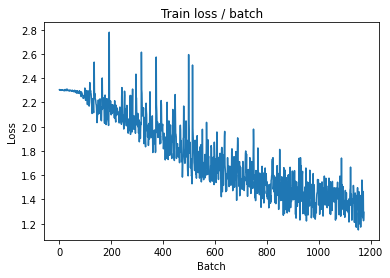

[TRAIN Batch 200/391]	Time 0.018s (0.031s)	Loss 1.2367 (1.3047)	Prec@1  57.0 ( 53.4)	Prec@5  93.8 ( 94.2)


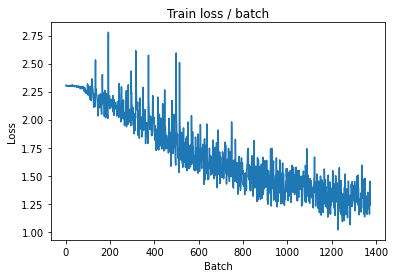


===============> Total time 11s	Avg loss 1.2745	Avg Prec@1 54.59 %	Avg Prec@5 94.53 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.0674 (1.0674)	Prec@1  63.3 ( 63.3)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.2096	Avg Prec@1 55.89 %	Avg Prec@5 95.26 %



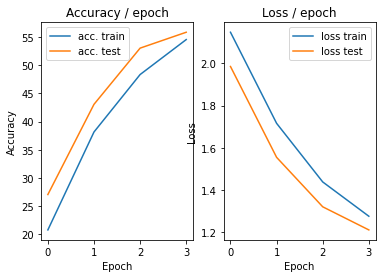

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 1.2007 (1.2007)	Prec@1  51.6 ( 51.6)	Prec@5  96.1 ( 96.1)


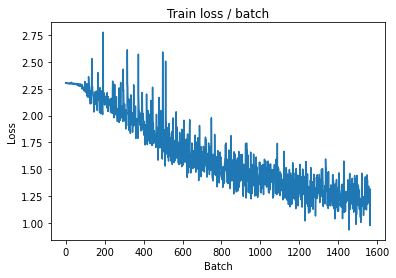

[TRAIN Batch 200/391]	Time 0.039s (0.032s)	Loss 1.1849 (1.1563)	Prec@1  51.6 ( 58.8)	Prec@5  96.1 ( 95.7)


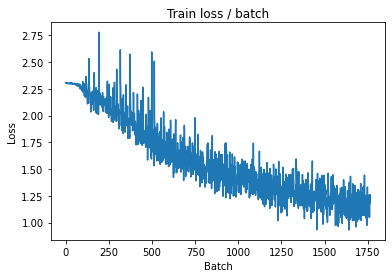


===============> Total time 12s	Avg loss 1.1367	Avg Prec@1 59.61 %	Avg Prec@5 95.81 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 1.1856 (1.1856)	Prec@1  59.4 ( 59.4)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.2352	Avg Prec@1 56.57 %	Avg Prec@5 94.11 %



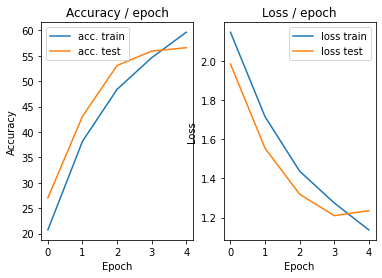

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 1.1200 (1.1200)	Prec@1  57.0 ( 57.0)	Prec@5  96.1 ( 96.1)


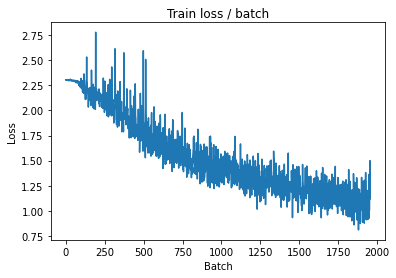

[TRAIN Batch 200/391]	Time 0.018s (0.031s)	Loss 1.1042 (1.0303)	Prec@1  60.9 ( 63.5)	Prec@5  95.3 ( 96.7)


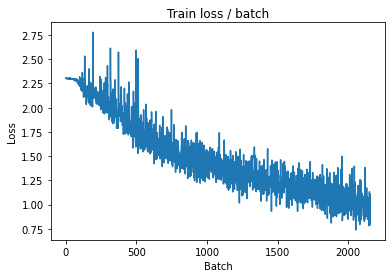


===============> Total time 12s	Avg loss 1.0126	Avg Prec@1 64.14 %	Avg Prec@5 96.73 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.9521 (0.9521)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0487	Avg Prec@1 63.20 %	Avg Prec@5 96.01 %



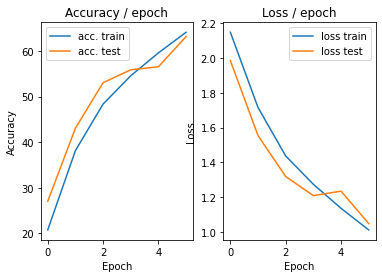

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.8368 (0.8368)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)


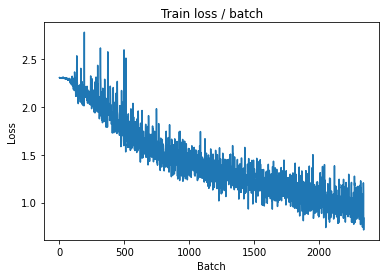

[TRAIN Batch 200/391]	Time 0.032s (0.031s)	Loss 0.8460 (0.9079)	Prec@1  68.0 ( 68.2)	Prec@5  97.7 ( 97.4)


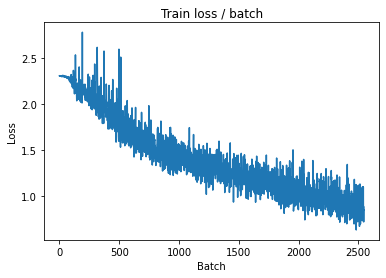


===============> Total time 11s	Avg loss 0.8972	Avg Prec@1 68.52 %	Avg Prec@5 97.62 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 1.0252 (1.0252)	Prec@1  58.6 ( 58.6)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.0758	Avg Prec@1 62.39 %	Avg Prec@5 96.29 %



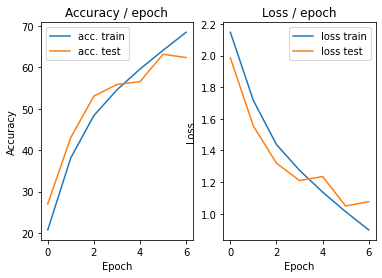

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.9201 (0.9201)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)


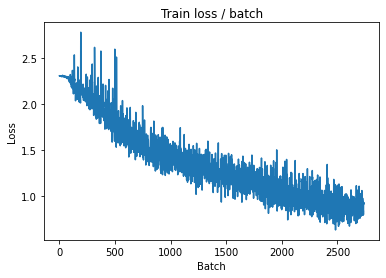

[TRAIN Batch 200/391]	Time 0.039s (0.031s)	Loss 0.7850 (0.7939)	Prec@1  66.4 ( 72.3)	Prec@5  97.7 ( 98.2)


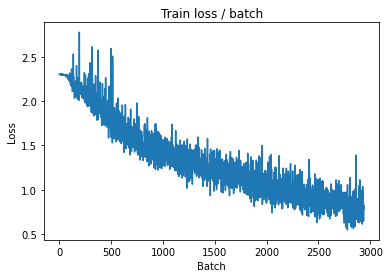


===============> Total time 12s	Avg loss 0.7941	Avg Prec@1 72.33 %	Avg Prec@5 98.11 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 0.9909 (0.9909)	Prec@1  66.4 ( 66.4)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.9745	Avg Prec@1 66.24 %	Avg Prec@5 96.92 %



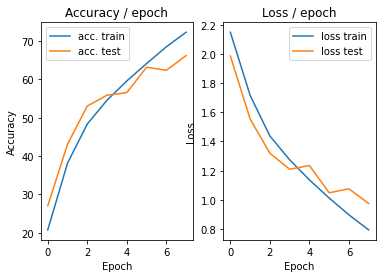

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.7037 (0.7037)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)


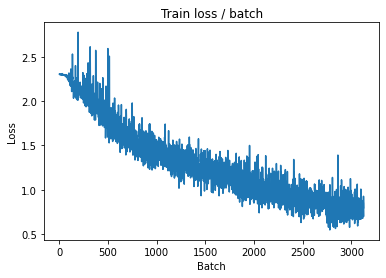

[TRAIN Batch 200/391]	Time 0.021s (0.031s)	Loss 0.5999 (0.6885)	Prec@1  80.5 ( 76.1)	Prec@5  99.2 ( 98.5)


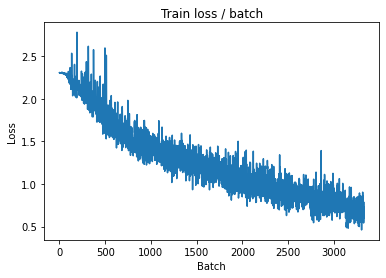


===============> Total time 11s	Avg loss 0.6919	Avg Prec@1 75.86 %	Avg Prec@5 98.59 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 0.8462 (0.8462)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9211	Avg Prec@1 69.29 %	Avg Prec@5 97.25 %



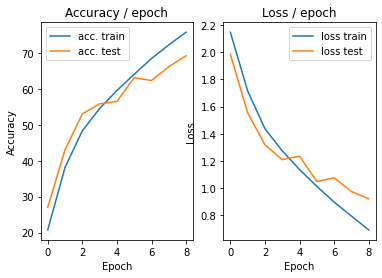

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.204s (0.204s)	Loss 0.6396 (0.6396)	Prec@1  78.9 ( 78.9)	Prec@5  97.7 ( 97.7)


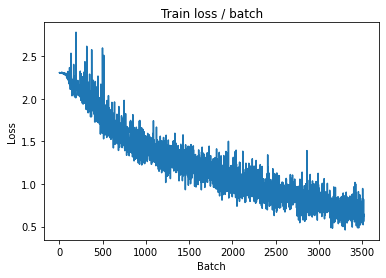

[TRAIN Batch 200/391]	Time 0.042s (0.031s)	Loss 0.5069 (0.5875)	Prec@1  81.2 ( 79.6)	Prec@5 100.0 ( 99.0)


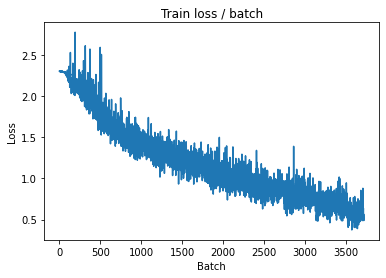


===============> Total time 12s	Avg loss 0.6000	Avg Prec@1 79.00 %	Avg Prec@5 99.07 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 0.9946 (0.9946)	Prec@1  64.8 ( 64.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.9940	Avg Prec@1 67.43 %	Avg Prec@5 97.03 %



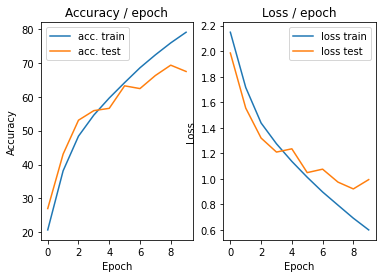

In [ ]:
main(128, 0.1, cuda=True, normalize=False)